### Setup

In [1]:
# Import packages needed
import numpy as np
import pandas as pd
import pickle
import os
os.environ["H5PY_DEFAULT_READONLY"] = "1" # Surpress h5py deprecation warnings
import socket
from datetime import datetime
from seticore import viewer # If you don't have it, use pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
import matplotlib.pyplot as plt
import setigen as stg
from astropy import units as u

%matplotlib inline
%load_ext autoreload
%autoreload 2


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/nstiegle


In [5]:
# Read in candidate hits
# candidates = pd.read_csv("/home/nstiegle/candidates.csv")
candidates = pd.read_csv("/home/nstiegle/candidates_indexed.csv")

# indices of promising candidates from visual inspection
indices = np.array([448, 323, 51, 53, 54, 218, 52, 325, 220, 453, 451, 450])

promising_candidates = candidates.iloc[indices]

### Generate indexed candidates

In [3]:
# Look for the stamp in a single stamp file
# Assumes the stamp_uri exists 
def find_stamp_in_single_file(stamp_uri, hit_frequency, threshold):
    # Check each stamp in the file to see if it matches
    stamps_gen = viewer.read_stamps(stamp_uri, find_recipe=True)
    for i, stamp in enumerate(stamps_gen):
        assert(stamp != None)
        assert(stamp.recipe != None)
        if abs(stamp.stamp.signal.frequency - hit_frequency) < threshold*1e-6:
            # Found the stamp!
            return i, stamp
    
    # Didn't find the stamp in this whole file of stamps
    return None, None

# Given a stamp_uri, increments the index of the stamp file by one (so if it's /.../...seticore.0000.stamps it goes to /.../...seticore.0001.stamps)
def increment_stamp_uri(stamp_uri):
    split_uri = stamp_uri.split('.')
    assert(split_uri[-1] == 'stamps')
    num = int(split_uri[-2])
    num += 1
    split_uri[-2] = str(num).zfill(4)
    return ".".join(split_uri)

# Finds where the stamp of a given hit is
# Takes:
# - stamp URI (of stamp file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location_helper(stamp_uri, hit_frequency, threshold):
    # Check stamp file passed in exists
    if not os.path.exists(stamp_uri):
        return None, None
    
    # Look for stamp in the stamp file given
    index, stamp = find_stamp_in_single_file(stamp_uri, hit_frequency, threshold)
    if (index != None) and (stamp != None):
        return stamp_uri, index
    else:
        # Check if there's another stamp file (because stamps can get split up into multiple files)
        return find_stamp_location_helper(increment_stamp_uri(stamp_uri), hit_frequency, threshold)

# Finds where the stamp of a given hit is
# Takes:
# - hit URI (of .hits file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location(hit_uri, hit_frequency, threshold=500):
    # Convert a filepath from pointing to a .hits
    # to a .stamps file for the same uri
    # If given a .stamps ending, doesn't change it
    def stamp_filepath_of(hits_filepath):
        return hits_filepath.replace('.hits', '.0000.stamps')

    return find_stamp_location_helper(stamp_filepath_of(hit_uri), hit_frequency, threshold)

In [5]:


# # Setup for multiprocessing
# import multiprocessing
# # Check if we need to remake the inputs array
# try:
#     assert(len(inputs) == len(candidates))
# except:
#     # Use multiprocessing to find the stamp files and the stamp indices for each candidate hit
#     inputs = [(candidates.iloc[i].file_uri, candidates.iloc[i].signal_frequency) for i in range(len(candidates))]
# p = multiprocessing.Pool() 

# # Run algorithm with multiprocessing
# results = p.starmap(find_stamp_location, inputs)

# # Save results (array of (stamp_uri, index) tuples)
# results = np.array(results)
# stamp_uris = results[:, 0]
# stamp_indices = results[:, 1]
# candidates["stamp_uri"] = stamp_uris
# candidates["stamp_index"] = stamp_indices
# candidates.to_csv("/home/nstiegle/candidates_indexed.csv")

### Make stamp pngs for each stamp

In [6]:
# import multiprocessing

# inputs = [(row.stamp_uri, row.stamp_index, row.source_name, row.id) for i, row in candidates.iterrows()]

# def plot_stamp(stamp_uri, stamp_index, source_name, id):
#     # Get the part of the stamp uri after the first / and up to 
#     def interesting_part_of_stamp_uri(stamp_uri):
#         return ".".join("".join(stamp_uri.split('/')[-1]).split(".")[:-1])
    
#     # Get the name and path of where to save these pngs
#     data_dir = "/mnt/cosmic-gpu-1/data0/nstiegle/candidate_plots/"
#     filename = f"stamp_{interesting_part_of_stamp_uri(stamp_uri)}_{stamp_index}"
#     path_to_save_to = data_dir + filename
    
#     # Get the stamps
#     stamps = [stamp for stamp in viewer.read_stamps(stamp_uri, find_recipe=True)]
#     stamp = stamps[stamp_index]

#     # Make the plots
#     title =  f"file {interesting_part_of_stamp_uri(stamp_uri)} index {stamp_index}\n"
#     title += f"Source: {source_name} ID: {id}\n"
#     title += f"Freq: {stamp.stamp.signal.frequency} DR: {stamp.stamp.signal.driftRate} SNR: {stamp.stamp.signal.snr}"
#     stamp.show_antennas(save_to=path_to_save_to + f"_antennas.png", title=title + ' antennas')
#     try:
#         stamp.show_best_beam(save_to=path_to_save_to + f"_coherent.png", title=title + ' coherent')
#     except:
#         stamp.show_beam(0, save_to=path_to_save_to + f"_coherent.png", title=title + ' coherent')
#     stamp.show_classic_incoherent(save_to=path_to_save_to + f"_incoherent.png", title=title + ' incoherent')


# p = multiprocessing.Pool() 

# # Run algorithm with multiprocessing
# results = p.starmap(plot_stamp, inputs)

### Make Results for Slides

In [6]:
len(promising_candidates)

12

In [9]:
promising_candidates.iloc[0]

Unnamed: 0                                                               448
Unnamed: 0.1                                                             448
id                                                                 959551322
signal_frequency                                                     24164.2
signal_drift_rate                                                    44.3833
signal_snr                                                           19.0125
signal_beam                                                                0
signal_power                                                     1.42148e+12
signal_incoherent_power                                          1.00334e+12
signal_num_timesteps                                                      16
tstart                                                               60295.5
tstart_h                                          2023-12-17 12:26:43.413109
ra_hours                                                             8.63873

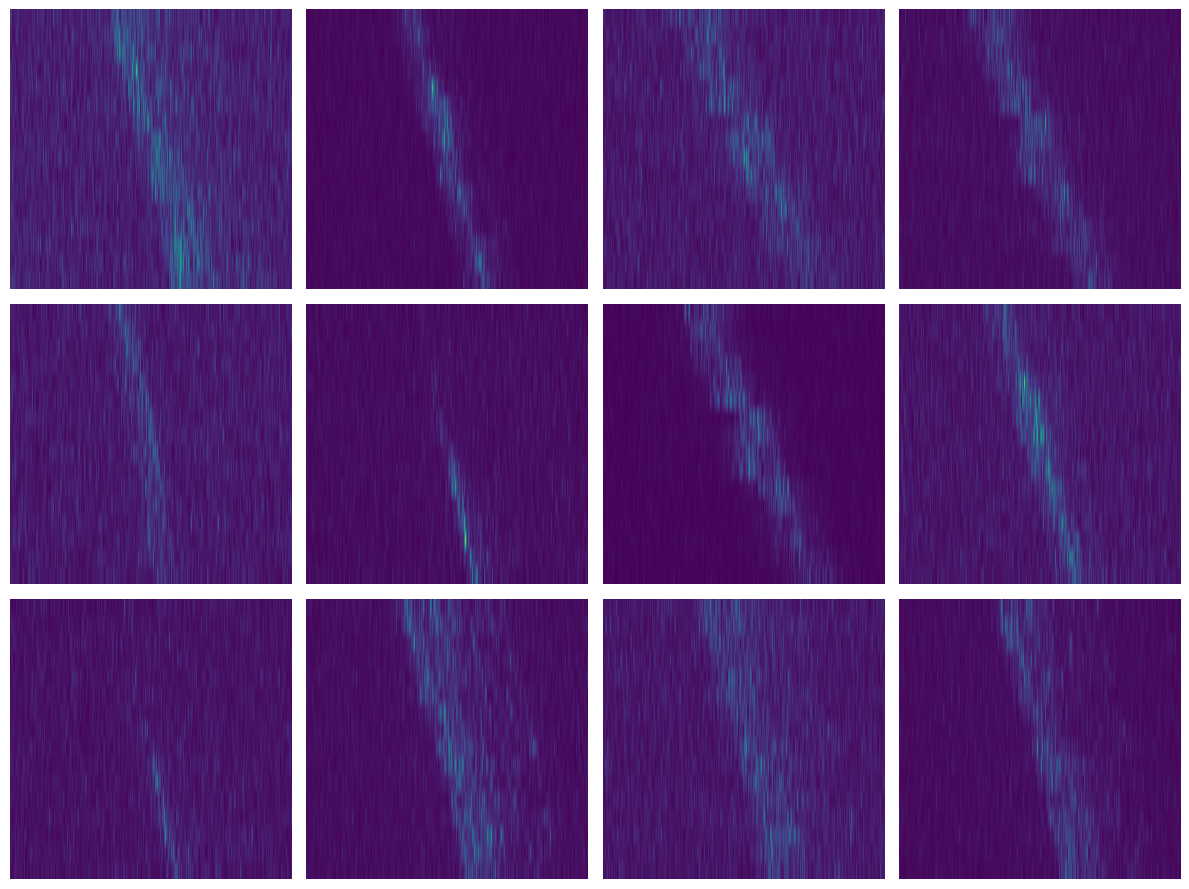

In [13]:
# Create a 4x3 grid of subplots (4 wide, 3 tall)
fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # Adjust the figsize as needed

# Function that returns data from inside stamp coherent
def stamp_coherent_data(stamp_uri, stamp_index, source_name, id):
    # Get the part of the stamp uri after the first / and up to 
    def interesting_part_of_stamp_uri(stamp_uri):
        return ".".join("".join(stamp_uri.split('/')[-1]).split(".")[:-1])
    
    # Get the name and path of where to save these pngs
    data_dir = "/mnt/cosmic-gpu-1/data0/nstiegle/candidate_plots/"
    filename = f"stamp_{interesting_part_of_stamp_uri(stamp_uri)}_{stamp_index}"
    path_to_save_to = data_dir + filename
    
    # Get the stamps
    stamps = [stamp for stamp in viewer.read_stamps(stamp_uri, find_recipe=True)]
    stamp = stamps[stamp_index]
    try:
        power = stamp.beamform_power(stamp.stamp.signal.beam)
    except:
        power = stamp.beamform_power(0)
    return power

# Loop through each subplot and create a heatmap
for i in range(3):
    for j in range(4):
        index = i * 4 + j
        ax = axes[i, j]
        row = promising_candidates.iloc[index]
        power = stamp_coherent_data(row.stamp_uri, row.stamp_index, row.source_name, row.id)
        heatmap = ax.imshow(power, cmap='viridis', aspect='auto')
        ax.axis('off')  # Optional: turn off the axis

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()